In [101]:
import bottleneck as bn
import dask
import folium
import holoviews as hv
import hvplot.xarray
import matplotlib.pyplot as plt
import numpy as np
import pystac_client
import xarray as xr
import yaml
import zarr
import gc
import os
import rioxarray

from tqdm import tqdm
from ascat.read_native.ragged_array_ts import CellFileCollection
from collections import defaultdict
from dask.distributed import Client
from odc import stac as odc_stac
import odc.stac
from pathlib import Path
from pyproj import Transformer
from scipy.spatial import cKDTree
import warnings
from collections import defaultdict

import requests
! pip install geopandas requests
import geopandas as gpd
import os

In [ ]:
#client = Client(processes=False, threads_per_worker=2, n_workers=3, memory_limit="512GB")
#client

### Loading Sentinel - 1 Sigma Naught Data from EODC STAC Catalogue

In [91]:
eodc_catalog = pystac_client.Client.open("https://stac.eodc.eu/api/v1")

collection_id = "SENTINEL1_SIG0_20M"

collection = eodc_catalog.get_collection(collection_id)

Setting time and area of interest.

In [ ]:
# Area for testing the code (selected area so e.g. the ffill is visible)
"""
time_range ="2022-01-06/2022-01-07" 

latmin, latmax = 44, 45         # South to North
lonmin, lonmax = 7, 8           # West to East

bounding_box = [lonmin, latmin, lonmax, latmax]
#"""

In [108]:
# Europe Africa Intersection
#"""
time_range ="2022-01-06/2022-01-07"

latmin, latmax = 35, 37            # South to North
lonmin, lonmax = -6, -5           # West to East

bounding_box = [lonmin, latmin, lonmax, latmax]
#"""

In [ ]:
# Whole Spatial Area but...
"""
#time_range ="2022-01-06T18:28:01.000000000" # one image
time_range = "2022-01-06/2022-01-06"  # one day

latmin, latmax = 30.0, 45.0            # South to North
lonmin, lonmax = -10.0, 5.0            # West to East

bounding_box = [lonmin, latmin, lonmax, latmax]
#"""

In [ ]:
# Area and Time of Interest
# This will not finish on your local pc
# Try to run in on a large Cluster
"""
time_range = "2021-01-01/2023-12-31"

latmin, latmax = 30.0, 45.0            # South to North
lonmin, lonmax = -10.0, 5.0            # West to East

bounding_box = [lonmin, latmin, lonmax, latmax]

#append to zar monthly ffill?
#"""

Loading the metadata with STAC search engine.

In [109]:
search = eodc_catalog.search(
    collections=collection_id,
    bbox=bounding_box,
    datetime=time_range,
    #max_items=1  # number of max items to load
)
items_eodc = search.item_collection()
print(f"On EODC we found {len(items_eodc)} items for the given search query")

On EODC we found 11 items for the given search query


This data is stored in the Equi7 grid. But our area of interest is in both the european Equi7 grid and the african Equi7 grid. 

Azimuthal Equidistant
- Center latitude: 53        -> Europa
- Center longitude: 24

Azimuthal Equidistant
- Center latitude: 8.5       -> Afrika
- Center longitude: 21.5

We will create two zar files for the different grids that can be fused later.

In [110]:
#"""
items_crs_europe = []
items_crs_africa = []
wkt_europe = None
wkt_africa = None

for item in items_eodc:
    wkt = item.properties["proj:wkt2"]
    lat_center = float(wkt.split('PARAMETER["latitude_of_center",')[1].split(']')[0])

    if lat_center == 53.0:
        items_crs_europe.append(item)
        wkt_europe = wkt
    elif lat_center == 8.5:
        items_crs_africa.append(item)
        wkt_africa = wkt

print(f"Equi7 Europe (lat 53.0): {len(items_crs_europe)} items")
print(wkt_europe, "\n")
print(f"Equi7 Africa (lat 8.5): {len(items_crs_africa)} items")
print(wkt_africa)
#"""

Equi7 Europe (lat 53.0): 5 items
PROJCS["Azimuthal_Equidistant",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Azimuthal_Equidistant"],PARAMETER["latitude_of_center",53],PARAMETER["longitude_of_center",24],PARAMETER["false_easting",5837287.81977],PARAMETER["false_northing",2121415.69617],UNIT["metre",1,AUTHORITY["EPSG","9001"]]] 

Equi7 Africa (lat 8.5): 6 items
PROJCS["Azimuthal_Equidistant",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Azimuthal_Equidistant"],PARAMETER["false_easting",5621452.01998],PARAMETER["false_northing",5990638.42298],PARAMETER["longitude_of_center",21.5],PARAMETER["latitude_of_center",8.5],UNIT["metre",1,AUTHORITY["EPSG",

In [120]:
# Europe and African tiles are grouped

def extract_tile_id_from_name(item_id):
    parts = item_id.split("_")
    tile_id = parts[3]
    if len(tile_id) == 10:
            return tile_id

european_tiles = defaultdict(list)
african_tiles = defaultdict(list)

for item in items_crs_europe:
    tile_id = extract_tile_id_from_name(item.id)
    if item not in european_tiles[tile_id]:
        european_tiles[tile_id].append(item)

for item in items_crs_africa:
    tile_id = extract_tile_id_from_name(item.id)
    if item not in african_tiles[tile_id]:
        african_tiles[tile_id].append(item)

european_tiles

defaultdict(list,
            {'E030N006T3': [<Item id=SIG0_20220107T062753_D154_E030N006T3_EU020M_V0M2R4_S1AIWGRDH>,
              <Item id=SIG0_20220107T062728_D154_E030N006T3_EU020M_V0M2R4_S1AIWGRDH>,
              <Item id=SIG0_20220107T062703_D154_E030N006T3_EU020M_V0M2R4_S1AIWGRDH>,
              <Item id=SIG0_20220106T182646_A147_E030N006T3_EU020M_V0M2R4_S1AIWGRDH>,
              <Item id=SIG0_20220106T182621_A147_E030N006T3_EU020M_V0M2R4_S1AIWGRDH>]})

### Information on Equi7 grid:
https://cartography.tuwien.ac.at/eurocarto/wp-content/uploads/2015/09/3_6_ppt.pdf

which tiles do we even want to run? Maybe decide on this later. Now try to run the compute on one tile

- Quickly test loading only one tile
- Then tink of how to combine them

Let's plot thumbnail of the loaded items for this area and those dates.

In [123]:
# Showing thumbnail image of the data
#"""
map = folium.Map(
    location=[(latmin + latmax) / 2, (lonmin + lonmax) / 2],
    zoom_start=7,
    zoom_control=True,
    scrollWheelZoom=False,
    dragging=False,
)

folium.Rectangle(
    bounds=[[latmin, lonmin], [latmax, lonmax]],
    color="blue",
    fill=True,
    fill_opacity=0.1,
    weight=2,
    popup="Area of Interest",
).add_to(map)

for item in european_tiles['E030N006T3']:
    # url leading to display of an item, can also be used as hyperlink
    image_url = item.assets["thumbnail"].href
    bounds = item.bbox
    folium.raster_layers.ImageOverlay(
        image=image_url,
        bounds=[[bounds[1], bounds[0]], [bounds[3], bounds[2]]],
    ).add_to(map)

folium.LayerControl().add_to(map)

map
#"""

## Loadig the shapefiles to mask data from europe and africa
The water could also be removed

In [124]:
import os, requests, geopandas as gpd
from shapely.geometry import mapping


download_dir = "equi7grid_shapefiles"
os.makedirs(download_dir, exist_ok=True)
tiles = {
    'EU': 'EQUI7_V14_EU_PROJ_TILE_T3',
    'AF': 'EQUI7_V14_AF_PROJ_TILE_T3'
}
base_url = 'https://raw.githubusercontent.com/TUW-GEO/Equi7Grid/master/src/equi7grid/grids/{}/PROJ/{}{}'
exts = ['.shp', '.shx', '.dbf', '.prj']

for code, name in tiles.items():
    for ext in exts:
        url = base_url.format(code, name, ext)
        path = os.path.join(download_dir, name + ext)
        try:
            r = requests.get(url); r.raise_for_status()
            with open(path, 'wb') as f: f.write(r.content)
        except Exception as e:
            print(f"Failed: {url} ({e})")

gdf_eu = gpd.read_file(os.path.join(download_dir, tiles['EU'] + '.shp'))
gdf_af = gpd.read_file(os.path.join(download_dir, tiles['AF'] + '.shp'))

In [136]:
crs = "EPSG:27704"

chunks = {"time": 1, "y": 15000, "x": 15000}
sig0_dc = odc_stac.load(
    european_tiles['E030N006T3'],
    resolution=20, # errror if not set
    crs=crs,                                       
    chunks=chunks,
)

nodata = items_eodc[0].assets["VV"].extra_fields["raster:bands"][0]["nodata"]
scale = items_eodc[0].assets["VV"].extra_fields["raster:bands"][0]["scale"]

sig0_dc = sig0_dc.where(sig0_dc != nodata) / scale

sig0_dc


<xarray.Dataset> Size: 9GB
Dimensions:      (y: 15000, x: 15000, time: 5)
Coordinates:
  * y            (y) float64 120kB 9e+05 9e+05 9e+05 ... 6e+05 6e+05 6e+05
  * x            (x) float64 120kB 3e+06 3e+06 3e+06 ... 3.3e+06 3.3e+06 3.3e+06
    spatial_ref  int32 4B 27704
  * time         (time) datetime64[ns] 40B 2022-01-06T18:26:21 ... 2022-01-07...
Data variables:
    VH           (time, y, x) float32 4GB dask.array<chunksize=(1, 15000, 15000), meta=np.ndarray>
    VV           (time, y, x) float32 4GB dask.array<chunksize=(1, 15000, 15000), meta=np.ndarray>

In [137]:
# Transform to linear scale to do calculations 
sig0_dc_linear = 10 ** (sig0_dc / 10)

# Merge in time direction 
sig0_dc_linear.coords['time'] = sig0_dc_linear.time.dt.ceil('1H')
sig0_dc_linear_hourly = sig0_dc_linear.groupby('time').mean(skipna=True)

# Lower the resolution from 20m to 6.24km  (as 6.25km does not work because 312.5 is not an int())
sig0_dc_linear_6km = sig0_dc_linear_hourly.coarsen(x=312, y=312, boundary="pad").mean() # padded with NA

# ffill values 
sig_dc_linear_6km_filled = sig0_dc_linear_6km.ffill(dim="time")

# Convert back to dB
sig_dc_6km = 10 * np.log10(sig_dc_linear_6km_filled)

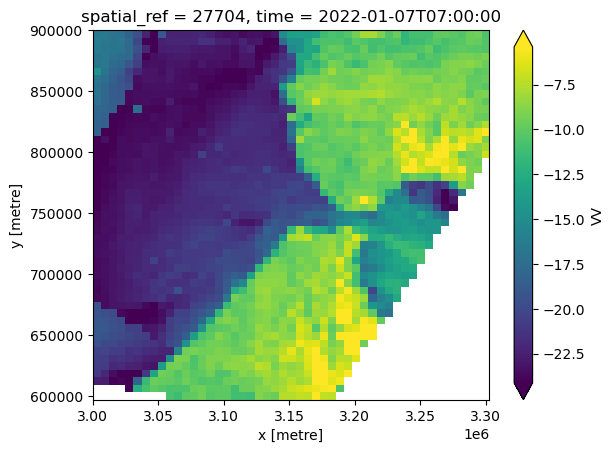

In [139]:
sig_dc_6km.VV.isel(time=1).plot.imshow(robust=True)
plt.show()

In [ ]:
target_tile = gdf_eu[gdf_eu["TILE"] == "E030N006T3"]
sig0_dc_clipped = sig_dc_6km.rio.clip(
    target_tile.geometry.apply(mapping).tolist(),
    drop=True
)


sig0_dc_clipped.VV.isel(time=1).plot.imshow(robust=True)
plt.show()

In [ ]:
sig_dc_6km.to_zarr("output_6km_filled.zarr", mode="w") 
# append to zarr 

KeyboardInterrupt: 

In [16]:
# Show steps visually:
""" only run if in testing mode

sig0_dc_linear.VV.plot.imshow(col="time", col_wrap=3, robust=True)
plt.show()

sig0_dc_linear_hourly.VV.plot.imshow(col="time", col_wrap=2, robust=True)
plt.show()

sig0_dc_linear_6km.VV.plot.imshow(col="time", col_wrap=2, robust=True)
plt.show()

sig_dc_linear_6km_filled.VV.plot.imshow(col="time", col_wrap=2, robust=True)
plt.show()
#"""

' only run if in testing mode\n\nsig0_dc_linear.VV.plot.imshow(col="time", col_wrap=3, robust=True)\nplt.show()\n\nsig0_dc_linear_hourly.VV.plot.imshow(col="time", col_wrap=2, robust=True)\nplt.show()\n\nsig0_dc_linear_6km.VV.plot.imshow(col="time", col_wrap=2, robust=True)\nplt.show()\n\nsig_dc_linear_6km_filled.VV.plot.imshow(col="time", col_wrap=2, robust=True)\nplt.show()\n#'

In [105]:
sig0_dc_linear.VV.plot.imshow(col="time", col_wrap=3, robust=True)
plt.show()

ValueError: Coordinates used for faceting cannot contain repeated (nonunique) values.

# Run code tile-by-tile

In [ ]:
def process_tile(tile_id, tiles_dict, crs, output_dir, items_eodc):
    res = 20
    chunks = {"time": 1, "latitude": 100, "longitude": 100}
    try:
        sig0_dc = odc_stac.load(
            tiles_dict[tile_id],
            crs=crs,
            resolution=res,
            chunks=chunks,
            resampling="bilinear",                         # not good for dB data?! -> nearest would be better
        )

        nodata = items_eodc[0].assets["VV"].extra_fields["raster:bands"][0]["nodata"]
        scale = items_eodc[0].assets["VV"].extra_fields["raster:bands"][0]["scale"]

        sig0_dc = sig0_dc.where(sig0_dc != nodata) / scale
        sig0_dc_linear = 10 ** (sig0_dc / 10)

        sig0_dc_linear_hourly = sig0_dc_linear.resample(time="1h").mean(dim="time").persist()
        sig0_dc_linear_hourly = sig0_dc_linear_hourly.dropna(dim="time", how="all")
        sig0_dc_linear_6km = sig0_dc_linear_hourly.coarsen(x=312, y=312, boundary="pad").mean()
        sig_dc_linear_6km_filled = sig0_dc_linear_6km.ffill(dim="time")
        
        sig_dc_6km = 10 * np.log10(sig_dc_linear_6km_filled)

        os.makedirs(output_dir, exist_ok=True)
        output_path = os.path.join(output_dir, f"{tile_id}.zarr")
        sig_dc_6km.to_zarr(output_path, mode="w")
        print(f"Processed and saved: {output_path}")

        # Clean up memory
        del sig0_dc, sig0_dc_linear, sig0_dc_linear_hourly, sig0_dc_linear_6km, sig_dc_linear_6km_filled, sig_dc_6km
        gc.collect()

    except Exception as e:
        print(f"Error processing tile {tile_id}: {e}")


## Processing European Tiles

In [ ]:
for tile_id, items_list in tqdm(european_tiles.items(), desc="Processing European Tiles"):
    process_tile(
        tile_id=tile_id,
        tiles_dict=european_tiles,
        crs="EPSG:27704",  # Europe CRS
        output_dir="sentinel_data/europe",
        items_eodc=items_list
    )

## Processing African Tiles

In [ ]:
for tile_id, items_list in tqdm(african_tiles.items(), desc="Processing African Tiles"):
    process_tile(
        tile_id=tile_id,
        tiles_dict=african_tiles,
        crs="EPSG:27701",  # Africa CRS
        output_dir="sentinel_data/africa",
        items_eodc=items_list
    )


In [115]:
gdf_eu['geometry']

0      POLYGON ((5400000 5400000, 5400000 5475000, 54...
1      POLYGON ((5700000 5400000, 5700000 5475000, 57...
2      POLYGON ((6000000 5400000, 6000000 5475000, 60...
3      POLYGON ((5100000 5100000, 5100000 5175000, 51...
4      POLYGON ((5400000 5100000, 5400000 5175000, 54...
                             ...                        
335    POLYGON ((5700000 0, 5700000 75000, 5700000 15...
336    POLYGON ((6000000 0, 6000000 75000, 6000000 15...
337    POLYGON ((6300000 0, 6300000 75000, 6300000 15...
338    POLYGON ((6600000 0, 6600000 75000, 6600000 15...
339    POLYGON ((6900000 0, 6900000 75000, 6900000 15...
Name: geometry, Length: 340, dtype: geometry

In [112]:
gdf_af

,GRID,VERSION,ZONE,SHORTNAME,TILE,EXTENT,EASTINGLL,NORTHINGLL,COVERSLAND,geometry
0,Equi7Grid,V14,Africa,E7G_AF,E036N093T3,300000,3600000,9300000,0,"POLYGON ((3600000 9300000, 3600000 9375000, 36..."
1,Equi7Grid,V14,Africa,E7G_AF,E039N093T3,300000,3900000,9300000,0,"POLYGON ((3900000 9300000, 3900000 9375000, 39..."
2,Equi7Grid,V14,Africa,E7G_AF,E042N093T3,300000,4200000,9300000,0,"POLYGON ((4200000 9300000, 4200000 9375000, 42..."
3,Equi7Grid,V14,Africa,E7G_AF,E072N093T3,300000,7200000,9300000,1,"POLYGON ((7200000 9300000, 7200000 9375000, 72..."
4,Equi7Grid,V14,Africa,E7G_AF,E075N093T3,300000,7500000,9300000,1,"POLYGON ((7500000 9300000, 7500000 9375000, 75..."
...,...,...,...,...,...,...,...,...,...,...
999,Equi7Grid,V14,Africa,E7G_AF,E024N000T3,300000,2400000,0,0,"POLYGON ((2400000 0, 2400000 75000, 2400000 15..."
1000,Equi7Grid,V14,Africa,E7G_AF,E027N000T3,300000,2700000,0,0,"POLYGON ((2700000 0, 2700000 75000, 2700000 15..."
1001,Equi7Grid,V14,Africa,E7G_AF,E030N000T3,300000,3000000,0,0,"POLYGON ((3000000 0, 3000000 75000, 3000000 15..."
1002,Equi7Grid,V14,Africa,E7G_AF,E033N000T3,300000,3300000,0,0,"POLYGON ((3300000 0, 3300000 75000, 3300000 15..."
